In [1]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import seaborn as sns
import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [2]:
# used for scaling numerical data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

In [3]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [4]:
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [5]:
features = pd.Series(X.satisfaction) 

In [6]:
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

In [7]:
# node2vec train data
t = pd.read_csv('embeddings', delimiter = " ", index_col=0, header = None)
t.sort_index(inplace=True)
t = t.to_numpy()
t.shape

(6000, 2)

In [8]:
Z = pd.DataFrame(t,columns = ['x1','x2'])

In [9]:
# node2vec train
XXXX = pd.DataFrame()
#XXXX = x_wd.copy(deep=True)
XXXX['z1'] = Z.x1
XXXX['z2'] = Z.x2
XXXX_label = pd.get_dummies(features)
XXXX

,z1,z2
0,-2.182478,-1.100291
1,1.367040,-1.080112
2,1.113928,-1.034789
3,0.160458,-0.891286
4,-2.345489,-1.135601
...,...,...
5995,-2.270933,-1.119560
5996,-2.452666,-1.176118
5997,-2.381334,-1.126160
5998,-2.257186,-1.132487


In [10]:
# node2vec test
t_test = pd.read_csv('embeddings_test', delimiter = " ", index_col=0, header = None)
t_test.sort_index(inplace=True)
t_test = t_test.to_numpy()
t_test.shape

(6000, 2)

In [11]:
Z_test = pd.DataFrame(t_test,columns = ['x1','x2'])

In [12]:
n2v_test_df = pd.read_csv('TEST_DF')
n2v_test_df.drop(columns=['Unnamed: 0'],inplace=True)
n2v_test_label = n2v_test_df.satisfaction
n2v_test_feats = n2v_test_df.drop(columns=['satisfaction'])
n2v_test_feats_dummy = pd.get_dummies(data=n2v_test_feats,columns=['Customer Type','Type of Travel','Gender'])
n2v_test_feats_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(n2v_test_feats_dummy[['Age','Departure Delay in Minutes','Flight Distance']])

In [13]:
TTTTTT_label = pd.get_dummies(n2v_test_label)
TTTTTT_label_tf = tf.convert_to_tensor(TTTTTT_label)
TTTTTT = pd.DataFrame()
#TTTTTT = n2v_test_feats_dummy.copy(deep=True)
TTTTTT['z1'] = Z_test.x1
TTTTTT['z2'] = Z_test.x2
TTTTTT_tf = tf.convert_to_tensor(TTTTTT)
TTTTTT

,z1,z2
0,1.263135,0.618403
1,1.227722,0.551899
2,0.637869,-0.539068
3,0.713818,-0.362981
4,0.987218,0.193263
...,...,...
5995,0.531026,-0.869078
5996,1.252779,0.602329
5997,0.986113,0.201152
5998,1.264823,0.629945


In [14]:
P = sm.add_constant(t) 
log_reg = sm.Logit(features, P).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.517356
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5997
Method:                           MLE   Df Model:                            2
Date:                Thu, 01 Jul 2021   Pseudo R-squ.:                  0.2427
Time:                        16:10:49   Log-Likelihood:                -3104.1
converged:                       True   LL-Null:                       -4099.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7051      0.366    -10.135      0.000      -4.422      -2.989
x1             0.9593      0.

In [15]:
predictions = log_reg.predict(P) 

yhat_log = np.empty((len(predictions),1))

for i in range(len(predictions)):
    if predictions[i] < 0.5:
        yhat_log[i] = 0
    else:         
        yhat_log[i] = 1

print('Classification Accuracy validation set {}'.format(accuracy_score(features,yhat_log)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(features,yhat_log))

Classification Accuracy validation set 0.7668333333333334
-------------------------------------------------------------
Confusion Matrix validation set:
[[2612  811]
 [ 588 1989]]


In [16]:
x_train, x_test, y_train, y_test = train_test_split(XXXX,XXXX_label, test_size = 0.2, shuffle=True)

In [17]:
x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(15, activation='relu'))
#model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=200, batch_size=10)

Epoch 1/200
480/480 [==============================] - 5s 9ms/step - loss: 0.5873 - accuracy: 0.7203 - val_loss: 0.5048 - val_accuracy: 0.7825
Epoch 2/200
480/480 [==============================] - 2s 3ms/step - loss: 0.5246 - accuracy: 0.7591 - val_loss: 0.5010 - val_accuracy: 0.7842
Epoch 3/200
480/480 [==============================] - 1s 3ms/step - loss: 0.5210 - accuracy: 0.7693 - val_loss: 0.5013 - val_accuracy: 0.7808
Epoch 4/200
480/480 [==============================] - 2s 3ms/step - loss: 0.4978 - accuracy: 0.7825 - val_loss: 0.5004 - val_accuracy: 0.7817
Epoch 5/200
480/480 [==============================] - 1s 3ms/step - loss: 0.5171 - accuracy: 0.7630 - val_loss: 0.4986 - val_accuracy: 0.7842
Epoch 6/200
480/480 [==============================] - 1s 1ms/step - loss: 0.5140 - accuracy: 0.7647 - val_loss: 0.4980 - val_accuracy: 0.7817
Epoch 7/200
480/480 [==============================] - 1s 1ms/step - loss: 0.5129 - accuracy: 0.7680 - val_loss: 0.4986 - val_accuracy: 0.7817

Epoch 58/200
480/480 [==============================] - 1s 1ms/step - loss: 0.5298 - accuracy: 0.7540 - val_loss: 0.4972 - val_accuracy: 0.7808
Epoch 59/200
480/480 [==============================] - 1s 1ms/step - loss: 0.5139 - accuracy: 0.7652 - val_loss: 0.4973 - val_accuracy: 0.7817
Epoch 60/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5186 - accuracy: 0.7656 - val_loss: 0.4975 - val_accuracy: 0.7808
Epoch 61/200
480/480 [==============================] - 1s 1ms/step - loss: 0.5231 - accuracy: 0.7626 - val_loss: 0.4973 - val_accuracy: 0.7808
Epoch 62/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5244 - accuracy: 0.7628 - val_loss: 0.4980 - val_accuracy: 0.7825
Epoch 63/200
480/480 [==============================] - 1s 1ms/step - loss: 0.5119 - accuracy: 0.7631 - val_loss: 0.4982 - val_accuracy: 0.7800
Epoch 64/200
480/480 [==============================] - 1s 1ms/step - loss: 0.5191 - accuracy: 0.7606 - val_loss: 0.4973 - val_accuracy:

Epoch 115/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5150 - accuracy: 0.7608 - val_loss: 0.4975 - val_accuracy: 0.7825
Epoch 116/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5155 - accuracy: 0.7665 - val_loss: 0.4980 - val_accuracy: 0.7808
Epoch 117/200
480/480 [==============================] - 1s 1ms/step - loss: 0.5071 - accuracy: 0.7706 - val_loss: 0.4975 - val_accuracy: 0.7808
Epoch 118/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5222 - accuracy: 0.7620 - val_loss: 0.4973 - val_accuracy: 0.7817
Epoch 119/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5122 - accuracy: 0.7666 - val_loss: 0.4993 - val_accuracy: 0.7817
Epoch 120/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5211 - accuracy: 0.7591 - val_loss: 0.4976 - val_accuracy: 0.7817
Epoch 121/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5229 - accuracy: 0.7585 - val_loss: 0.4974 - val_ac

480/480 [==============================] - 1s 2ms/step - loss: 0.5147 - accuracy: 0.7661 - val_loss: 0.4980 - val_accuracy: 0.7800
Epoch 172/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5309 - accuracy: 0.7560 - val_loss: 0.4975 - val_accuracy: 0.7817
Epoch 173/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5244 - accuracy: 0.7538 - val_loss: 0.4978 - val_accuracy: 0.7808
Epoch 174/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5171 - accuracy: 0.7648 - val_loss: 0.4973 - val_accuracy: 0.7825
Epoch 175/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5234 - accuracy: 0.7548 - val_loss: 0.4983 - val_accuracy: 0.7817
Epoch 176/200
480/480 [==============================] - 1s 2ms/step - loss: 0.5115 - accuracy: 0.7692 - val_loss: 0.4981 - val_accuracy: 0.7817
Epoch 177/200
480/480 [==============================] - 2s 3ms/step - loss: 0.5192 - accuracy: 0.7599 - val_loss: 0.4974 - val_accuracy: 0.7842

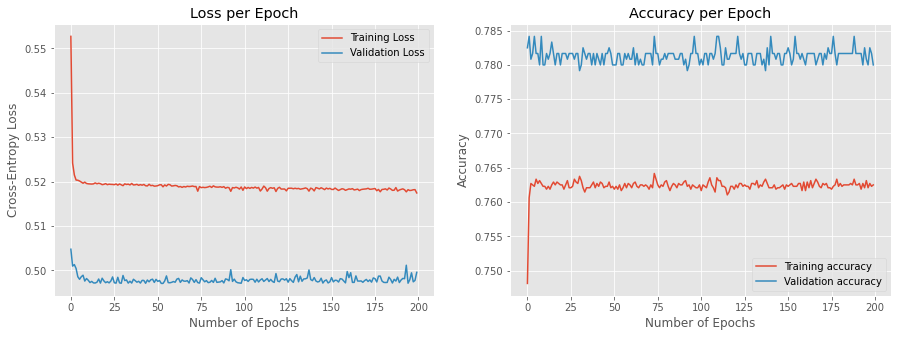

In [18]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [19]:
results = model.evaluate(TTTTTT_tf, TTTTTT_label_tf)
print("test loss, test acc:", results)

188/188 [==============================] - 1s 2ms/step - loss: 1.0173 - accuracy: 0.2677
test loss, test acc: [1.0173238515853882, 0.26766666769981384]


In [20]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(XXXX,svm_y, test_size = 0.2, shuffle=True)

In [21]:
svm_y_test = np.empty((len(n2v_test_label),1))

for i in range(len(n2v_test_label)):
    if n2v_test_label.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [22]:
clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.765
0.7741666666666667


In [23]:
y_pred = clf.predict(TTTTTT)
print(clf.score(TTTTTT, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

0.42233333333333334
0.42233333333333334


In [24]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

<ipython-input-24-dabfb3d76502>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


0.9997916666666666
0.7133333333333334


In [25]:
y_pred = clf.predict(TTTTTT)
print(clf.score(TTTTTT, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

0.3415
0.3329393888232315


In [26]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(TTTTTT)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(TTTTTT, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7670833333333333
0.765
0.6111666666666666
0.2707095967489841


In [27]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(TTTTTT)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(TTTTTT, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

0.7541666666666667
0.7691666666666667
0.5705
0.011507479861910242


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [28]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(TTTTTT, svm_y_test))

0.7552083333333334
0.7733333333333333
0.57


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [29]:
x_train, x_test, y_train, y_test = train_test_split(XXXX,features, test_size = 0.2, shuffle=True)
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
y_pred = clf.predict(TTTTTT)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(TTTTTT, n2v_test_label))

0.7710416666666666
0.75
0.5705


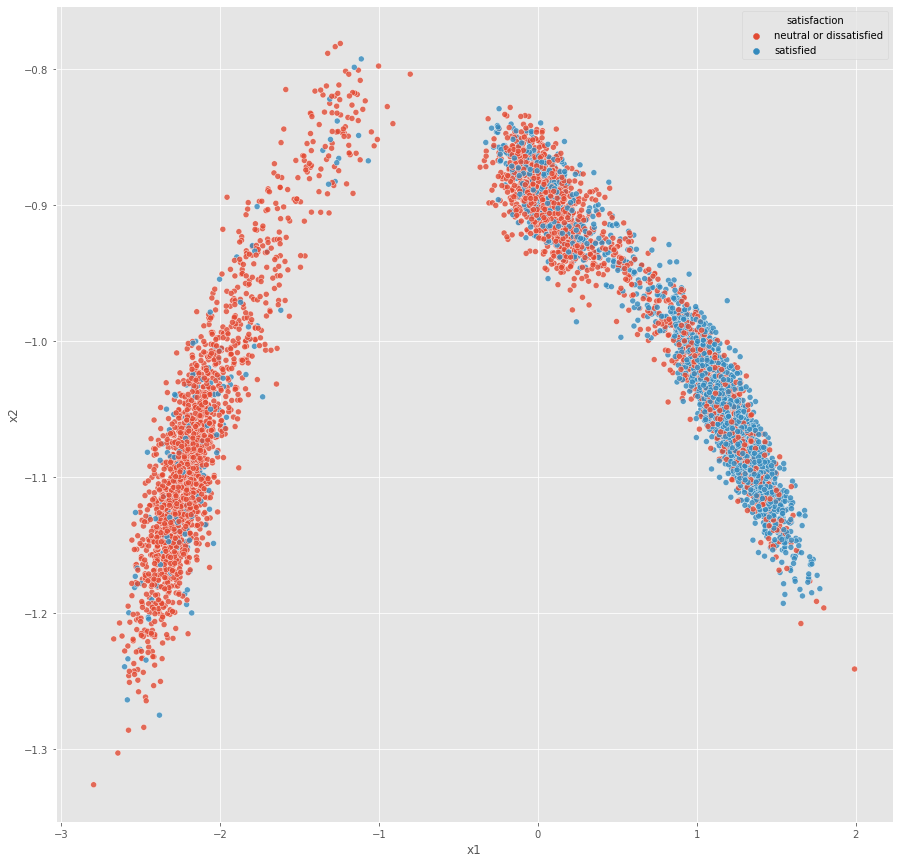

In [30]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=Z.x1,y=Z.x2,hue=df['satisfaction'],alpha=0.8)
plt.show()